Ashmita Phuyal(124454)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Load Data

There was an error while downloading the nltk data. So , I used the paragraphs from the pride and prejudice.

In [3]:
with open ("./data.txt", "r") as doc:
    corpus = doc.read()

In [4]:
corpus

'It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered as the rightful property of some one or other of their daughters.'

# 2. Tokenization

In [5]:
corpus = [corpus.split(" ") for sent in corpus]

In [9]:
print(len(corpus))

378


# 3. Numeralization

In [10]:
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [11]:
vocabs[:20]

['fortune,',
 'single',
 'as',
 'first',
 'wife.',
 'entering',
 'other',
 'little',
 'feelings',
 'want',
 'on',
 'known',
 'well',
 'views',
 'rightful',
 'truth',
 'acknowledged,',
 'good',
 'may',
 'fixed']

In [12]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}

In [13]:
#vocab size
voc_size = len(vocabs)
print(voc_size)

49


In [14]:
vocabs.append('<UNK>')
word2index['<UNK>'] = voc_size

In [15]:
index2word = {v:k for k, v in word2index.items()}

In [16]:
#vocab size
voc_size = len(vocabs)
print(voc_size)

50


# 4. Prepare train data

### Skipgram

In [17]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
        

In [18]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[46]
 [12]]
Target:  [[37]
 [19]]


### SkipgramNeg

In [19]:
z= 0.001

from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

26838

In [20]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)


In [121]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

### Build Co-occurence Matrix 

In [122]:
from collections import Counter

X_i = Counter(flatten(corpus))

In [123]:
skip_grams = []

for doc in corpus:
    for i in range(1, len(doc)-1):
        center = doc[i]
        outside = [doc[i-1], doc[i+1]]
        for each_out in outside:
            skip_grams.append((center, each_out))

In [124]:
X_ik_skipgrams = Counter(skip_grams)

### Weighting function

In [125]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [126]:
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

In [127]:
for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

### Glove

In [133]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

# 5. Model

Skipgram

In [115]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss
        

In [82]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)

In [83]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(50, 2)
  (embedding_outside): Embedding(50, 2)
)

In [88]:
x_sample, y_sample = random_batch(2, corpus)

input_tensor = torch.LongTensor(x_sample)
label_tensor = torch.LongTensor(y_sample)

loss = model(input_tensor, label_tensor, all_vocabs)

loss

tensor(4.7266, grad_fn=<NegBackward0>)

SkipgramNeg

In [128]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [129]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [130]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

loss = model(x_tensor, y_tensor, neg_samples)
loss

tensor(2.1872, grad_fn=<NegBackward0>)

Glove

In [202]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, cooc, weighting):
        center_embeds  = self.embedding_center(center) #(batch_size, 1, emb_size)
        outside_embeds = self.embedding_outside(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - cooc, 2)
        
        return torch.sum(loss)

In [135]:
#test our system
voc_size = len(vocabs)
emb_size = 2
batch_size = 2
model = Glove(voc_size, emb_size)

x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [136]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

loss

tensor(60.5746, grad_fn=<SumBackward0>)

GloVe(Gensim)

In [104]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [110]:
#you have to put this file in some python/gensim directory; just run it and it will inform where to put....
glove_file = datapath('glove.6B.100d.txt')  #search on the google
gensim = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gensim/test/test_data/glove.6B.100d.txt'

# 6. Training

Skipgram

In [198]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)
voc_size = len(vocabs)

In [203]:
Skipgrammodel = Skipgram(voc_size,emb_size)
SkipgramNegmodel = SkipgramNeg(voc_size,emb_size)
Glovemodel = Glove(voc_size,emb_size)

optimizer_skipgram = optim.Adam(Skipgrammodel.parameters(),lr=0.001)
optimizer_skipgramneg = optim.Adam(SkipgramNegmodel.parameters(),lr=0.001)
optimizer_glove = optim.Adam(Glovemodel.parameters(),lr=0.001)

In [116]:
import time

num_epochs = 5000

start_time = time.time()

for epoch in range(num_epochs):
    
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    # backpropagate
    optimizer.zero_grad()
    loss.backward()
    
    # update alpha
    optimizer.step()
    
    # print the loss
    if (epoch + 1) % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Elapsed Time: {elapsed_time:.2f} seconds")

end_time = time.time()

Epoch   1000 | Loss: 3.029451 | Elapsed Time: 36.44 seconds
Epoch   2000 | Loss: 3.878581 | Elapsed Time: 72.62 seconds
Epoch   3000 | Loss: 3.829605 | Elapsed Time: 109.61 seconds
Epoch   4000 | Loss: 3.401345 | Elapsed Time: 147.04 seconds
Epoch   5000 | Loss: 3.294563 | Elapsed Time: 185.38 seconds


In [117]:
# Calculate the total training time
total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds")

Total Training Time: 185.38 seconds


In [118]:
print(f'Training Loss: {loss}')

Training Loss: 3.294563055038452


Skipgram(Neg)

In [131]:
import time

num_epochs = 5000

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)

    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)

    # backpropagate
    optimizer.zero_grad()
    loss.backward()

    # update alpha
    optimizer.step()

    # Record the end time for each epoch
    epoch_end_time = time.time()

    # Calculate epoch time
    epoch_time = epoch_end_time - epoch_start_time

    # print the loss and epoch time
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Epoch Time: {epoch_time:.2f} seconds")


Epoch   1000 | Loss: 3.448101 | Epoch Time: 0.08 seconds
Epoch   2000 | Loss: 0.980379 | Epoch Time: 0.01 seconds
Epoch   3000 | Loss: 2.664328 | Epoch Time: 0.01 seconds
Epoch   4000 | Loss: 1.311838 | Epoch Time: 0.07 seconds
Epoch   5000 | Loss: 2.590053 | Epoch Time: 0.01 seconds


In [132]:
print(f'Training Loss: {loss}')

Training Loss: 2.590052604675293


GloVe

In [137]:
batch_size     = 5 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [138]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [139]:
import time

# Training
num_epochs = 5000
losses = []
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 170.314590 | time: 0m 0s
Epoch: 2000 | cost: 53.778023 | time: 0m 0s
Epoch: 3000 | cost: 49.967083 | time: 0m 0s
Epoch: 4000 | cost: 20.286005 | time: 0m 0s
Epoch: 5000 | cost: 13.801422 | time: 0m 0s


In [140]:
print(f'Training Loss: {loss}')

Training Loss: 13.801422119140625


## 7. Comparison

## Skipgram
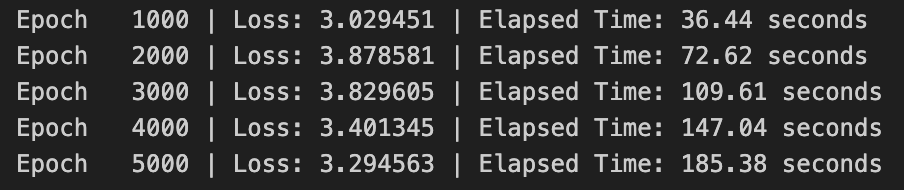

## Skipgram(Neg)
![Screenshot 2024-01-25 at 22.03.18.png](<attachment:Screenshot 2024-01-25 at 22.03.18.png>)

## GloVe
![Screenshot 2024-01-25 at 22.05.09.png](<attachment:Screenshot 2024-01-25 at 22.05.09.png>)
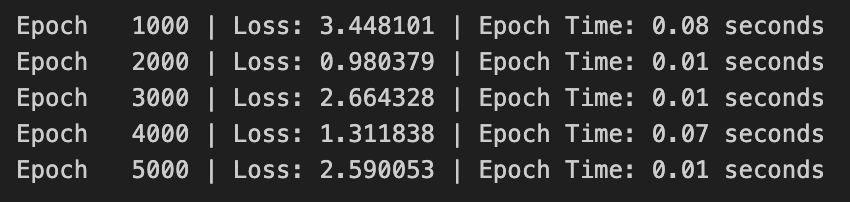
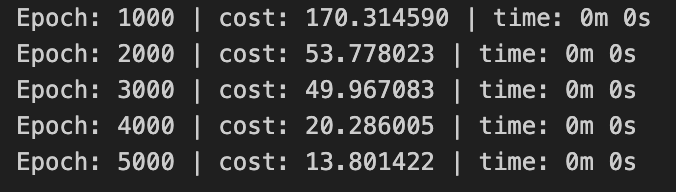

# 8. Syntatic and Semantic Accuracy

In [151]:
with open ("./word-test.v1.txt", "r") as doc:
    data = doc.read()

In [153]:
# Split the input string into lines
lines = data.split('\n')

# Create a list of lists
syntatic_data = [line.split() for line in lines]

print(syntatic_data)

[['Athens', 'Greece', 'Baghdad', 'Iraq'], ['Athens', 'Greece', 'Bangkok', 'Thailand'], ['Athens', 'Greece', 'Beijing', 'China'], ['Athens', 'Greece', 'Berlin', 'Germany'], ['Athens', 'Greece', 'Bern', 'Switzerland'], ['Athens', 'Greece', 'Cairo', 'Egypt'], ['Athens', 'Greece', 'Canberra', 'Australia'], ['Athens', 'Greece', 'Hanoi', 'Vietnam'], ['Athens', 'Greece', 'Havana', 'Cuba'], ['Athens', 'Greece', 'Helsinki', 'Finland'], ['Athens', 'Greece', 'Islamabad', 'Pakistan'], ['Athens', 'Greece', 'Kabul', 'Afghanistan'], ['Athens', 'Greece', 'London', 'England'], ['Athens', 'Greece', 'Madrid', 'Spain'], ['Athens', 'Greece', 'Moscow', 'Russia'], ['Athens', 'Greece', 'Oslo', 'Norway'], ['Athens', 'Greece', 'Ottawa', 'Canada'], ['Athens', 'Greece', 'Paris', 'France'], ['Athens', 'Greece', 'Rome', 'Italy'], ['Athens', 'Greece', 'Stockholm', 'Sweden'], ['Athens', 'Greece', 'Tehran', 'Iran'], ['Athens', 'Greece', 'Tokyo', 'Japan'], ['Baghdad', 'Iraq', 'Bangkok', 'Thailand'], ['Baghdad', 'Iraq',

In [154]:
with open ("./past tense.txt", "r") as doc:
    dataset = doc.read()

In [156]:
# Split the input string into lines
lines = dataset.split('\n')

# Create a list of lists
semantic_data = [line.split() for line in lines]

print(semantic_data)

[['dancing', 'danced', 'decreasing', 'decreased'], ['dancing', 'danced', 'describing', 'described'], ['dancing', 'danced', 'enhancing', 'enhanced'], ['dancing', 'danced', 'falling', 'fell'], ['dancing', 'danced', 'feeding', 'fed'], ['dancing', 'danced', 'flying', 'flew'], ['dancing', 'danced', 'generating', 'generated'], ['dancing', 'danced', 'going', 'went'], ['dancing', 'danced', 'hiding', 'hid'], ['dancing', 'danced', 'hitting', 'hit'], ['dancing', 'danced', 'implementing', 'implemented'], ['dancing', 'danced', 'increasing', 'increased'], ['dancing', 'danced', 'jumping', 'jumped'], ['dancing', 'danced', 'knowing', 'knew'], ['dancing', 'danced', 'listening', 'listened'], ['dancing', 'danced', 'looking', 'looked'], ['dancing', 'danced', 'moving', 'moved'], ['dancing', 'danced', 'paying', 'paid'], ['dancing', 'danced', 'playing', 'played'], ['dancing', 'danced', 'predicting', 'predicted'], ['dancing', 'danced', 'reading', 'read'], ['dancing', 'danced', 'running', 'ran'], ['dancing', 'd

In [157]:
semantic_data[:5], syntatic_data[:5]

([['dancing', 'danced', 'decreasing', 'decreased'],
  ['dancing', 'danced', 'describing', 'described'],
  ['dancing', 'danced', 'enhancing', 'enhanced'],
  ['dancing', 'danced', 'falling', 'fell'],
  ['dancing', 'danced', 'feeding', 'fed']],
 [['Athens', 'Greece', 'Baghdad', 'Iraq'],
  ['Athens', 'Greece', 'Bangkok', 'Thailand'],
  ['Athens', 'Greece', 'Beijing', 'China'],
  ['Athens', 'Greece', 'Berlin', 'Germany'],
  ['Athens', 'Greece', 'Bern', 'Switzerland']])

#### Embedding

In [190]:
def get_embed(model,word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([index])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [204]:
Skipgram_embeddings = get_embed(Skipgrammodel, vocabs)
SkipgramNeg_embeddings = get_embed(SkipgramNegmodel, vocabs)
Glove_embeddings = get_embed(Glovemodel, vocabs)

#### COSine Similiarity

In [150]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [205]:
# Define the cosine_similarity function
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

# Define the get_accuracy function
def get_accuracy(embedding_model, dataset, model="normal"):
    correct = 0
    total = 0
    for category in dataset:
        word_a, word_b, word_c, word_d = map(str.lower, category)
        if model == "normal":
            prediction = (get_single_embed(embedding_model, word_b) - 
                          get_single_embed(embedding_model, word_a) + 
                          get_single_embed(embedding_model, word_c))
            similar_words = get_most_similar_word(embedding_model, prediction, "cosine", 1)
            predicted_word = similar_words[0][0]
        elif model == "3cosadd":
            prediction = get_single_embed(embedding_model, word_b) - get_single_embed(embedding_model, word_a) + get_single_embed(embedding_model, word_c)
            similar_words = get_most_similar_word(embedding_model, prediction, "cosine", 1)
            predicted_word = similar_words[0][0]
        elif model == "3cosmul":
            prediction = get_single_embed(embedding_model, word_b) / get_single_embed(embedding_model, word_a) * get_single_embed(embedding_model, word_c)
            similar_words = get_most_similar_word(embedding_model, prediction, "cosine", 1)
            predicted_word = similar_words[0][0]
        if predicted_word == word_d:
            correct += 1
        total += 1
    return correct / total


In [ ]:
# Define the get_single_embed function
def get_single_embed(embedding_model, word):
    word = word.lower()
    try:
        return embedding_model[word]
    except KeyError:
        return embedding_model['']

# Define the get_most_similar_word function
def get_most_similar_word(embedding_model, vector, metric, k):
    similarities = {}
    for word in embedding_model:
        if word != '':
            similarities[word] = cosine_similarity(vector, embedding_model[word], metric)
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[:k]

# Calculate the accuracy for Skipgram
skipgram_accuracy = get_accuracy(Skipgram_embeddings, syntatic_data)
skipgram_semantic_accuracy = get_accuracy(Skipgram_embeddings, semantic_data)

# Calculate the accuracy for Skipgram Negative Sampling
skipgramneg_accuracy = get_accuracy(SkipgramNeg_embeddings, syntatic_data)
skipgramneg_semantic_accuracy = get_accuracy(SkipgramNeg_embeddings, semantic_data)

# Calculate the accuracy for GloVe
glove_accuracy = get_accuracy(GloVe_embeddings, syntatic_data)
glove_semantic_accuracy = get_accuracy(GloVe_embeddings, semantic_data)

print(f"Model Window Size Training Loss Training time Syntactic Accuracy Semantic accuracy")
print(f"Skipgram {model_window_size_skipgram} {training_loss_skipgram} {training_time_skipgram} {skipgram_accuracy} {skipgram_semantic_accuracy}")
print(f"Skipgram (NEG) {model_window_size_skipgram_neg} {training_loss_skipgram_neg} {training_time_skipgram_neg} {skipgramneg_accuracy} {skipgramneg_semantic_accuracy}")
print(f"Glove {model_window_size_glove} {training_loss_glove} {training_time_glove} {glove_accuracy} {glove_semantic_accuracy}")
